문제 정의: 타이타닉 생존자 예측 데이터 셋 사용하여 유무를 예측하는 이진 분류 문제로 정의 <br>
사망: 0, 생존: 1

라이브러리 임포트

In [1]:
# Libraries for reading and handling the data
import numpy
import pandas
import re

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn

# Libraries for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Libraries for creating ML model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Library for Analysing the ML model
from sklearn import metrics

데이터 준비하기

In [2]:
train_path = 'train.csv'

target = 'Survived'

index = 'PassengerId'

dtypes = ({
    'Survived': bool, 
    'Pclass':   'category', 
    'Name':     'category',
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})

데이터 준비하기

In [3]:
titanic = pandas.read_csv(train_path, index_col = index, dtype = dtypes)

In [4]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


데이터 시각화

In [5]:
titanic['Survived'].value_counts()

False    549
True     342
Name: Survived, dtype: int64

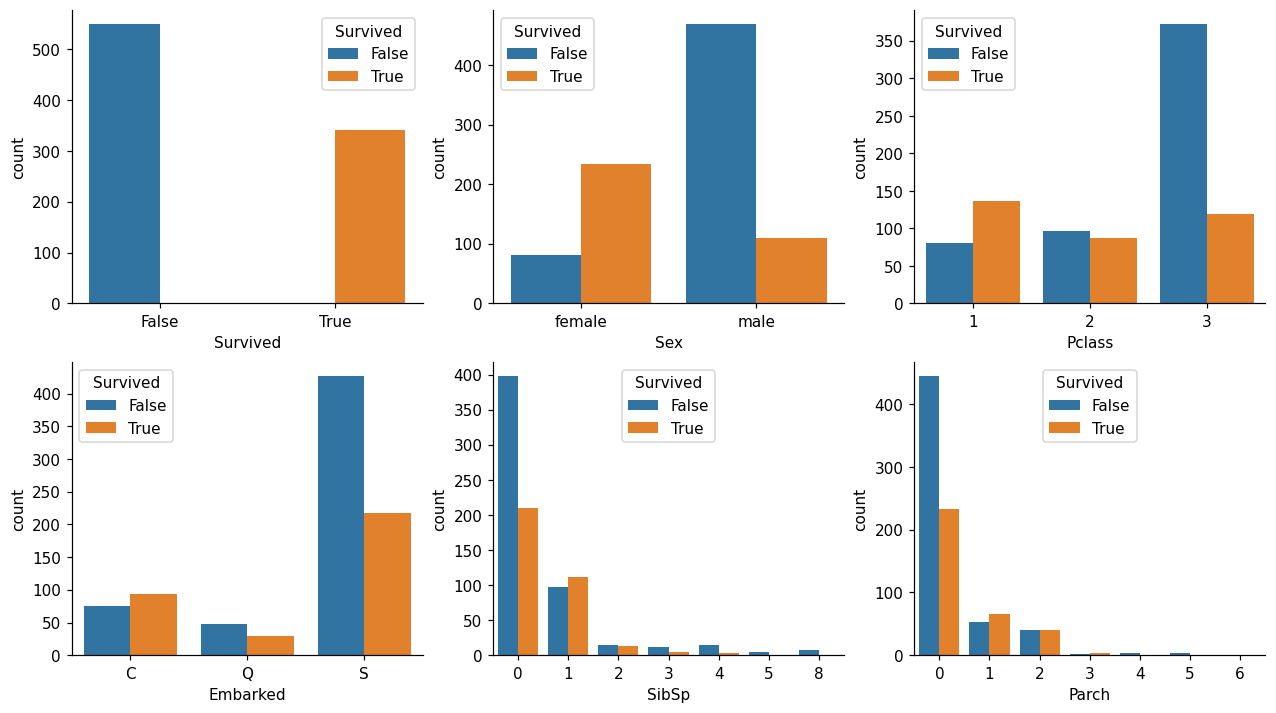

In [6]:
attributes = ['Survived', 'Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']

plt.figure(figsize = (14, 12), dpi = 110)

for i, feature in enumerate(attributes):
  plt.subplot(3, 3, i+1)
  seaborn.countplot(data = titanic, x = feature, hue = 'Survived')

seaborn.despine()

데이터 전처리

In [7]:
titanic['Name'].iloc[0:5]

PassengerId
1                              Braund, Mr. Owen Harris
2    Cumings, Mrs. John Bradley (Florence Briggs Th...
3                               Heikkinen, Miss. Laina
4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                             Allen, Mr. William Henry
Name: Name, dtype: category
Categories (891, object): ['Abbing, Mr. Anthony', 'Abbott, Mr. Rossmore Edward',
                           'Abbott, Mrs. Stanton (Rosa Hunt)', 'Abelson, Mr. Samuel', ..., 'de Pelsmaeker, Mr. Alfons',
                           'del Carlo, Mr. Sebastiano', 'van Billiard, Mr. Austin Blyler',
                           'van Melkebeke, Mr. Philemon']

In [8]:
def get_title(name):
  return re.split(',|\.', name)[1].strip()

In [9]:
titanic['Name'].apply(get_title)

PassengerId
1        Mr
2       Mrs
3      Miss
4       Mrs
5        Mr
       ... 
887     Rev
888    Miss
889    Miss
890      Mr
891      Mr
Name: Name, Length: 891, dtype: object

In [10]:
# 이름에서 호칭 추출 (Miss, Mr ...)
titanic['title'] = titanic['Name'].apply(get_title)
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
PassengerId,,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [11]:
# 호칭이 생존에 과연 영향을 끼치는지 확인을 위해서 집계 함수 -> 카운트, 평균
titles = titanic.groupby('title').agg({'Survived' : ['count', 'mean']})

In [12]:
# Survived 컬럼 레이어 정리
titles.columns = titles.columns.droplevel()

In [13]:
# 생존 평균이 높은 순으로 정렬
titles.sort_values('mean', ascending = False)

,count,mean
title,,
the Countess,1,1.000000
Mlle,2,1.000000
Sir,1,1.000000
Ms,1,1.000000
Lady,1,1.000000
Mme,1,1.000000
Mrs,125,0.792000
Miss,182,0.697802
Master,40,0.575000


In [14]:
# 호칭 추출이 되지 않은 title값을 Other로 처리
uncommon_titles = (['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 
                    'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 
                    'the Countess', 'Jonkheer'])
titanic['title'] = titanic['title'].replace(uncommon_titles, 'other')

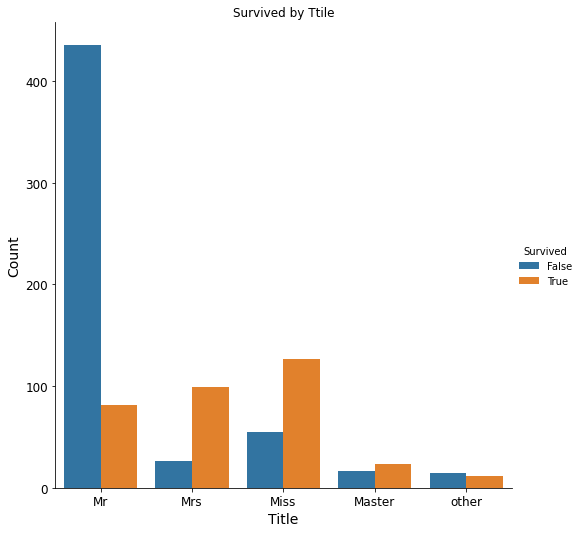

In [15]:
seaborn.catplot(x = 'title', kind = 'count', hue = 'Survived',
                data = titanic, height = 7)
plt.tick_params(labelsize = 12)
plt.ylabel('Count', fontsize = 14)
plt.xlabel('Title', fontsize = 14)
plt.title('Survived by Ttile')
plt.show()

In [16]:
# 가족 사이즈(fam_size) -> SibSp(동승한 자매 or 배우자) + Parch(동승한 부모 | 자식수)
titanic['fam_size'] = titanic['SibSp'] + titanic['Parch']

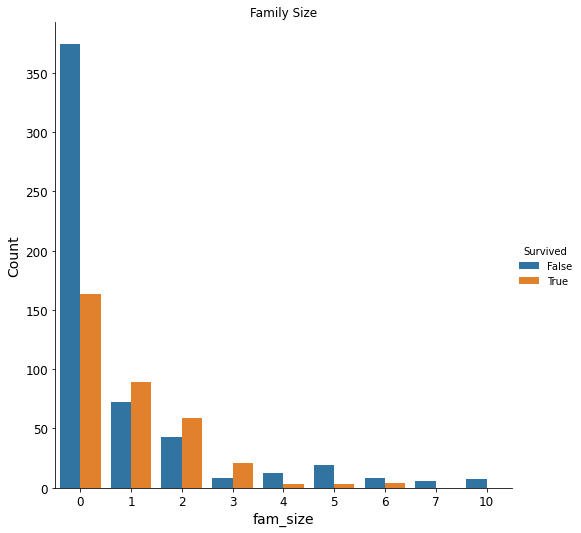

In [17]:
seaborn.catplot(x = 'fam_size', kind = 'count', hue = 'Survived',
                data = titanic, height = 7)

plt.tick_params(labelsize = 12)
plt.ylabel('Count', fontsize = 14)
plt.xlabel('fam_size', fontsize = 14)
plt.title('Family Size')
plt.show()

ML을 위한 전처리

In [18]:
# 텍스트 데이터 삭제
titanic = titanic.drop(['Name','Ticket','Cabin', 'Embarked','title'], axis=1)

In [19]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,male,22.0,1,0,7.2500,1
2,True,1,female,38.0,1,0,71.2833,1
3,True,3,female,26.0,0,0,7.9250,0
4,True,1,female,35.0,1,0,53.1000,1
5,False,3,male,35.0,0,0,8.0500,0


In [20]:
# 여성을 1로, 남성을 0으로 처리하고 싶을 때
tmp = []
for each in titanic['Sex']:
  if each == 'female':
    tmp.append(1)
  elif each == 'male':
    tmp.append(0)
  else:
    tmp.append(numpy.nan)

titanic['Sex'] = tmp

In [21]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,0,22.0,1,0,7.2500,1
2,True,1,1,38.0,1,0,71.2833,1
3,True,3,1,26.0,0,0,7.9250,0
4,True,1,1,35.0,1,0,53.1000,1
5,False,3,0,35.0,0,0,8.0500,0


데이터 형변환 및 결손 데이터 처리

In [22]:
# 데이터 형 변환 (소수점)
titanic['Pclass'] = titanic['Pclass'].astype('float')
titanic['Sex'] = titanic['Sex'].astype('float')
titanic['SibSp'] = titanic['SibSp'].astype('float')
titanic['Parch'] = titanic['Parch'].astype('float')
titanic['Fare'] = titanic['Fare'].astype('float')

#null(결손) 값인 경우 삭제
titanic = titanic[titanic['Survived'].notnull()]
titanic = titanic[titanic['Age'].notnull()]
titanic = titanic[titanic['SibSp'].notnull()]
titanic = titanic[titanic['Parch'].notnull()]
titanic = titanic[titanic['Fare'].notnull()]

In [23]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    bool   
 1   Pclass    714 non-null    float64
 2   Sex       714 non-null    float64
 3   Age       714 non-null    float64
 4   SibSp     714 non-null    float64
 5   Parch     714 non-null    float64
 6   Fare      714 non-null    float64
 7   fam_size  714 non-null    int64  
dtypes: bool(1), float64(6), int64(1)
memory usage: 45.3 KB


데이터 분리 하기 X(문제집), y(정답)

In [24]:
titanic_labels = titanic['Survived'].copy()
titanic = titanic.drop('Survived', axis = 1)

훈련 데이터, 테스트 데이터셋 분리하기

In [25]:
X_train, X_test, y_train, y_test = train_test_split(titanic,
                                                    titanic_labels,
                                                    train_size = 0.8) # 훈련 데이터 80%

머신러닝 모델 구축 - 1) LogisticRegression

In [26]:
log_reg = LogisticRegression().fit(X_train, y_train)

In [27]:
# 정확도 확인
print('Train data Score: ', log_reg.score(X_train, y_train))
print('Test data Score: ', log_reg.score(X_test, y_test))

Train data Score:  0.8038528896672504
Test data Score:  0.8181818181818182


머신러닝 모델 구축 - 2) Decision Tree

In [28]:
tree = DecisionTreeClassifier(max_depth = 5,
                              min_samples_leaf = 20,
                              min_samples_split = 40).fit(X_train, y_train)

In [29]:
# 정확도 확인
print('Train data Score: ', tree.score(X_train, y_train))
print('Test data Score: ', tree.score(X_test, y_test))

Train data Score:  0.8213660245183888
Test data Score:  0.7692307692307693


머신러닝 모델 구축 - 3) GradientBoostingClassifier

In [30]:
boost = GradientBoostingClassifier(max_depth = 3,
                                  learning_rate = 0.05).fit(X_train, y_train)

In [31]:
# 정확도 확인
print('Train data Score: ', boost.score(X_train, y_train))
print('Test data Score: ', boost.score(X_test, y_test))

Train data Score:  0.8844133099824869
Test data Score:  0.8251748251748252


머신러닝 모델 구축 - 4) RandomForestClassifier

In [32]:
random = RandomForestClassifier(n_estimators = 300,
                                random_state = 0).fit(X_train, y_train)

In [33]:
# 정확도 확인
print('Train data Score: ', random.score(X_train, y_train))
print('Test data Score: ', random.score(X_test, y_test))

Train data Score:  0.9859894921190894
Test data Score:  0.8391608391608392


성능평가 - ROC 커브

In [34]:
def plot_auc_roc(model):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

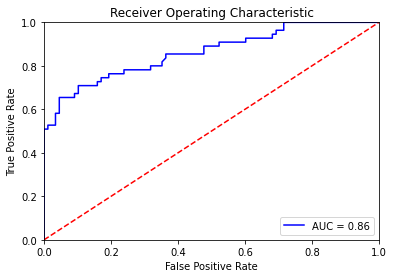

In [35]:
# Logistic Regression
plot_auc_roc(log_reg)

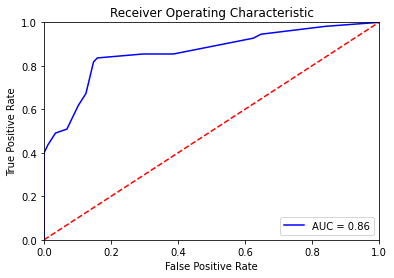

In [36]:
# Decision Tree
plot_auc_roc(tree)

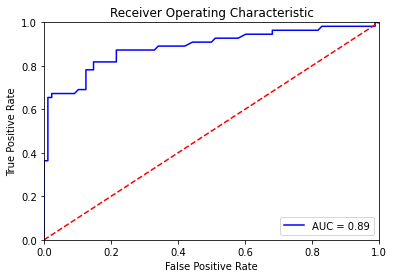

In [37]:
# GradientBoostingClassifie
plot_auc_roc(boost)

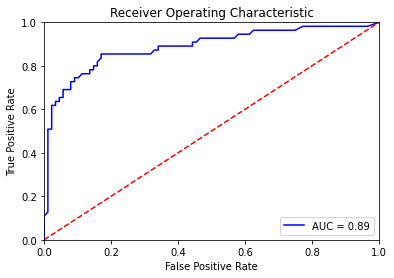

In [38]:
# RandomForestClassifier
plot_auc_roc(random)

모델 성능 평가

In [40]:
# Logistic Regression 평가 지표
lg_y_hat = log_reg.predict(X_test)
lg_report = metrics.classification_report(y_test, lg_y_hat)
print('Logistic Regression 평가 지표')
print(lg_report)
print('accuracy', metrics.accuracy_score(y_test,lg_y_hat) )
print('precision', metrics.precision_score(y_test,lg_y_hat) )
print('recall', metrics.recall_score(y_test,lg_y_hat) )
print('f1', metrics.f1_score(y_test,lg_y_hat) )

Logistic Regression 평가 지표
              precision    recall  f1-score   support

       False       0.82      0.90      0.86        88
        True       0.81      0.69      0.75        55

    accuracy                           0.82       143
   macro avg       0.82      0.79      0.80       143
weighted avg       0.82      0.82      0.82       143

accuracy 0.8181818181818182
precision 0.8085106382978723
recall 0.6909090909090909
f1 0.7450980392156863


In [41]:
# Decision Tree 평가 지표
tree_y_hat = tree.predict(X_test)
tree_report = metrics.classification_report(y_test, tree_y_hat)
print('Decision Tree 평가 지표')
print(tree_report)
print('accuracy', metrics.accuracy_score(y_test,tree_y_hat) )
print('precision', metrics.precision_score(y_test,tree_y_hat) )
print('recall', metrics.recall_score(y_test,tree_y_hat) )
print('f1', metrics.f1_score(y_test,tree_y_hat) )

Decision Tree 평가 지표
              precision    recall  f1-score   support

       False       0.75      0.93      0.83        88
        True       0.82      0.51      0.63        55

    accuracy                           0.77       143
   macro avg       0.79      0.72      0.73       143
weighted avg       0.78      0.77      0.75       143

accuracy 0.7692307692307693
precision 0.8235294117647058
recall 0.509090909090909
f1 0.6292134831460674


In [42]:
# GradientBoostingClassifie 평가 지표
boost_y_hat = boost.predict(X_test)
boost_report = metrics.classification_report(y_test, boost_y_hat)
print('GradientBoostingClassifie 평가 지표')
print(boost_report)
print('accuracy', metrics.accuracy_score(y_test,boost_y_hat) )
print('precision', metrics.precision_score(y_test,boost_y_hat) )
print('recall', metrics.recall_score(y_test,boost_y_hat) )
print('f1', metrics.f1_score(y_test,boost_y_hat) )

GradientBoostingClassifie 평가 지표
              precision    recall  f1-score   support

       False       0.82      0.92      0.87        88
        True       0.84      0.67      0.75        55

    accuracy                           0.83       143
   macro avg       0.83      0.80      0.81       143
weighted avg       0.83      0.83      0.82       143

accuracy 0.8251748251748252
precision 0.8409090909090909
recall 0.6727272727272727
f1 0.7474747474747475


In [44]:
# RandomForestClassifier 평가 지표
random_y_hat = boost.predict(X_test)
random_report = metrics.classification_report(y_test, random_y_hat)
print('RandomForestClassifier 평가 지표')
print(random_report)
print('accuracy', metrics.accuracy_score(y_test,random_y_hat) )
print('precision', metrics.precision_score(y_test,random_y_hat) )
print('recall', metrics.recall_score(y_test,random_y_hat) )
print('f1', metrics.f1_score(y_test,random_y_hat) )

RandomForestClassifier 평가 지표
              precision    recall  f1-score   support

       False       0.82      0.92      0.87        88
        True       0.84      0.67      0.75        55

    accuracy                           0.83       143
   macro avg       0.83      0.80      0.81       143
weighted avg       0.83      0.83      0.82       143

accuracy 0.8251748251748252
precision 0.8409090909090909
recall 0.6727272727272727
f1 0.7474747474747475


성능평가 - 평가 지표(classification_report)

In [45]:
precision_list = []
recall_list = []    # 잘못 예측할 경우 critical한 경우 recall 높은 모델을 선택
                    # precision, recall 둘 다 중요할 경우엔 f1 높은 것으로 선택

precision_list.append(metrics.precision_score(y_test, lg_y_hat))
recall_list.append(metrics.recall_score(y_test, lg_y_hat))

precision_list.append(metrics.precision_score(y_test, tree_y_hat))
recall_list.append(metrics.recall_score(y_test, tree_y_hat))

precision_list.append(metrics.precision_score(y_test, boost_y_hat))
recall_list.append(metrics.recall_score(y_test, boost_y_hat))

precision_list.append(metrics.precision_score(y_test, random_y_hat))
recall_list.append(metrics.recall_score(y_test, random_y_hat))

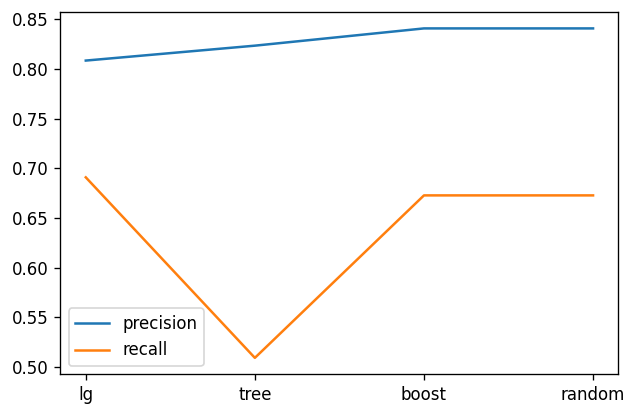

In [47]:
plt.figure(dpi = 120)
plt.plot(['lg', 'tree', 'boost', 'random'], precision_list, label = 'precision')
plt.plot(['lg', 'tree', 'boost', 'random'], recall_list, label = 'recall')
plt.legend()
plt.show()